### Case Study 5 (Advanced): Vision ML — Label Merging + Per-Class Stats

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.DataFrame({
    'image_id': ['cph001.jpg', 'ber005.jpg', 'sf103.jpg', 'del220.jpg', 'nyc009.jpg'],
    'annotator_labels': [
        ['car', 'human', 'truck'],        # inconsistent naming
        ['person', 'bicycle'],
        ['automobile', 'person'],
        ['vehicle', 'motorbike'],
        ['pedestrian', 'bike', 'car']
    ],
    'city': ['Copenhagen', 'Berlin', 'San Francisco', 'Delhi', 'New York']
})
df

,image_id,annotator_labels,city
0,cph001.jpg,"[car, human, truck]",Copenhagen
1,ber005.jpg,"[person, bicycle]",Berlin
2,sf103.jpg,"[automobile, person]",San Francisco
3,del220.jpg,"[vehicle, motorbike]",Delhi
4,nyc009.jpg,"[pedestrian, bike, car]",New York


In [4]:
synonym_map = {
    'automobile': 'car',
    'vehicle': 'car',
    'human': 'person',
    'pedestrian': 'person',
    'bike': 'bicycle',
}

In [7]:
def normalize_labels(label_list, mapping):
    return sorted(set([mapping.get(l,l) for l in label_list]))

df['normalized_labels'] = df['annotator_labels'].apply(lambda x: normalize_labels(x, synonym_map))
df

,image_id,annotator_labels,city,normalized_labels
0,cph001.jpg,"[car, human, truck]",Copenhagen,"[car, person, truck]"
1,ber005.jpg,"[person, bicycle]",Berlin,"[bicycle, person]"
2,sf103.jpg,"[automobile, person]",San Francisco,"[car, person]"
3,del220.jpg,"[vehicle, motorbike]",Delhi,"[car, motorbike]"
4,nyc009.jpg,"[pedestrian, bike, car]",New York,"[bicycle, car, person]"


In [9]:
from collections import Counter
stats_by_city = {}
for city, group in df.groupby('city'):
    labels = sum(group['normalized_labels'], [])
    stats = dict(Counter(labels))
    stats_by_city[city] = stats


city_stats_df = pd.DataFrame(stats_by_city).fillna(0).astype(int)
city_stats_df

,Berlin,Copenhagen,Delhi,New York,San Francisco
bicycle,1,0,0,1,0
person,1,1,0,1,1
car,0,1,1,1,1
truck,0,1,0,0,0
motorbike,0,0,1,0,0


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(df['normalized_labels'])
co_matrix = np.dot(onehot.T, onehot)

co_df = pd.DataFrame(co_matrix, index=mlb.classes_, columns=mlb.classes_)
co_df

,bicycle,car,motorbike,person,truck
bicycle,2,1,0,2,0
car,1,4,1,3,1
motorbike,0,1,1,0,0
person,2,3,0,4,1
truck,0,1,0,1,1


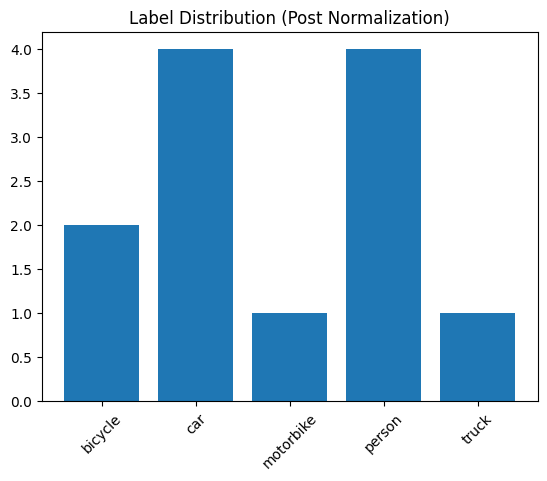

In [12]:
import matplotlib.pyplot as plt

label_totals = onehot.sum(axis=0)
plt.bar(mlb.classes_, label_totals)
plt.xticks(rotation=45)
plt.title("Label Distribution (Post Normalization)")
plt.show()


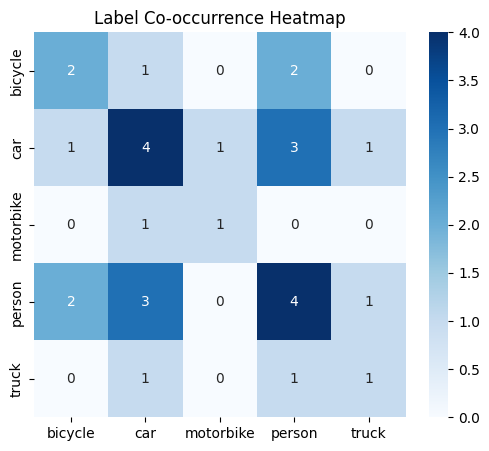

In [13]:
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(co_df, annot=True, fmt='d', cmap='Blues')
plt.title("Label Co-occurrence Heatmap")
plt.show()

In [14]:
mlb.classes_

array(['bicycle', 'car', 'motorbike', 'person', 'truck'], dtype=object)

In [15]:
# Define thresholds
strong_threshold = 2
rare_threshold = 0

# Find strong correlations (excluding diagonal)
strong_pairs = []
rare_pairs = []

for i, label1 in enumerate(mlb.classes_):
    for j, label2 in enumerate(mlb.classes_):
        if i < j: # avoid duplicates and diagonal
            value = co_df.iloc[i,j]
            if value >= strong_threshold:
                strong_pairs.append((label1, label2, value))
            elif value <= rare_threshold:
                rare_pairs.append((label1, label2, value))
print("Strong Co-occurrence Pairs:")
for pair in strong_pairs:
    print(f"  - {pair[0]} & {pair[1]}: {pair[2]} times")

print("\nRare or Never Co-occurring Pairs:")
for pair in rare_pairs:
    print(f"  - {pair[0]} & {pair[1]}: {pair[2]} times")

Strong Co-occurrence Pairs:
  - bicycle & person: 2 times
  - car & person: 3 times

Rare or Never Co-occurring Pairs:
  - bicycle & motorbike: 0 times
  - bicycle & truck: 0 times
  - motorbike & person: 0 times
  - motorbike & truck: 0 times
